In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        i+=1
        print(os.path.join(dirname, filename))
        if i==10:
            break
    if i==10:
        break


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-2023-abdominal-trauma-detection/train_dicom_tags.parquet
/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv
/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv
/kaggle/input/rsna-2023-abdominal-trauma-detection/test_dicom_tags.parquet
/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv
/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv
/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv
/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/26501/22032/12.dcm
/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/26501/22032/120.dcm
/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/26501/22032/141.dcm


In [3]:
data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/'

In [4]:
! pip install pydicom

In [5]:
#Importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import pydicom
from glob import glob
import random

print('installed')

installed


In [6]:
import torch
import torchvision.models as models

# Save ResNet-18
resnet_model = models.resnet18(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.save(resnet_model.state_dict(), '/kaggle/working/resnet18.pth')

# Save DenseNet121
densenet_model = models.densenet121(pretrained=True)
densenet_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.save(densenet_model.state_dict(), '/kaggle/working/densenet121.pth')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [7]:
import os
i=0
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        i+=1
        print(os.path.join(dirname, filename))
        if i==10:
            break
    if i==10:
        break

/kaggle/working/resnet18.pth
/kaggle/working/densenet121.pth


In [8]:
# Define hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 3

In [9]:
#Define data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [10]:
# Load the CSV file with labels
import pandas as pd
labels_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')

In [11]:
# Create a dictionary to store labels for each patient
labels_dict = {row['patient_id']: row[['bowel_healthy', 'bowel_injury', 'extravasation_healthy', 'extravasation_injury',
                                       'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low',
                                       'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']].values
               for _, row in labels_df.iterrows()}

In [12]:
# Defining custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, labels_dict, transform=None):
        self.data_dir = data_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.image_paths = glob(os.path.join(data_dir, '**', '*.dcm'), recursive=True)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        #print(f'Loading item {index}')
        image_path = self.image_paths[index]
        dicom_data = pydicom.dcmread(image_path)
        pixel_data = dicom_data.pixel_array
        
        # Normalize pixel data to range [0, 1]
        pixel_data = pixel_data / 255.0  # pixel values are in the range [0, 255]
        
        # Convert pixel data to a PIL image
        image = Image.fromarray(pixel_data)
        
        
        patient_id = int(image_path.split('/')[-3])  # Extract patient ID from path
        label = torch.tensor(self.labels_dict[patient_id], dtype=torch.float32).float()

        if self.transform is not None:
            image = self.transform(image)
        #print(f'Patient ID: {patient_id}')
        return image, label

In [13]:
#Loading Train Dataset and Trainloader

train_dataset = CustomDataset(data_dir, labels_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

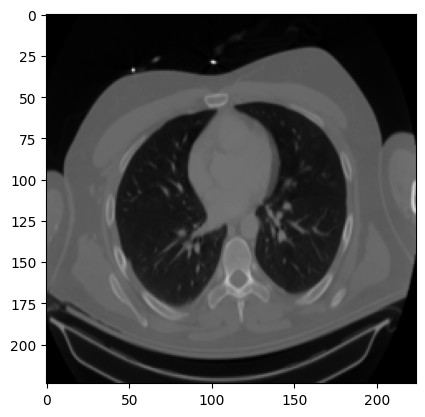

In [14]:
# Choosing and Displaying an image to decide similarities
# This image choosed from the middle part of the body where the organ we interested.
# This images will use to find most similar images for each patient.
# It could be change depends on the patient for future studies.

from collections import defaultdict
patient_images = defaultdict(list)
for image_path in train_dataset.image_paths:
    patient_id = int(image_path.split('/')[-3])
    patient_images[patient_id].append(image_path)
    
dicom_data = pydicom.dcmread(patient_images[23424][0])
pixel_data = dicom_data.pixel_array / 255.0  # Normalize pixel data
image = Image.fromarray(pixel_data)
if transform is not None:
    image = transform(image)
plt.imshow(image.squeeze(), cmap='gray')
plt.show();

In [15]:
# patient_images is a dictionary that includes the images for patient by batient 

len(patient_images) , labels_df.patient_id.nunique() # shows how many unic patient we have

(3147, 3147)

In [16]:
# showing the number of patient who has at least one injury

sum(labels_df.any_injury)

855

In [17]:
# showing the number of patient who has at least one injury

injury_patientid=list(labels_df.query('any_injury == 1')['patient_id'])
len(injury_patientid)

855

In [18]:
# checking the result

injury_patientid[:10]

[10004, 10051, 10065, 10127, 10132, 10163, 10217, 10228, 10292, 10295]

In [19]:
# Create a dictionary which includes patients that have at least one injury from patient images dictionary

def select_items_by_keys(input_dict, keys_list):
    return {key: input_dict[key] for key in keys_list if key in input_dict}

# Example usage 
# patient_images is a dictionary that has all images for each patient
# injury_patientid is a list that has patient id who has any injury


injury_patient_images = select_items_by_keys(patient_images, injury_patientid)
print(list(injury_patient_images.keys())[:10])

[10004, 10051, 10065, 10127, 10132, 10163, 10217, 10228, 10292, 10295]


In [20]:
# copying the images to a new dictionary. This dictionary will be used in the next code cells.
reduced_patient_images = patient_images.copy()

In [21]:
# checking the result that everythig is fine.
len(reduced_patient_images)

3147

In [22]:
# Our dataset is an imbalanced dataset. This dataset should be made as a balanced dataset without don't lose the patient who has at least one injury.
# We have total 3147 patient id. 855 of them has any injury. The dataset will be decreased the number of patient id from 3147 to 1710. 
# 855 of 1710 has any injury. 855 of 1710 has no injury. These no injury patient ids will be choosed as randomly. 
# To remove 1437 patient who has no injury will increase the balancity and also the accuracy of the prediction of model. 

def delete_random_items(target_dict, reference_dict, num_items_to_delete):
    target_keys = list(target_dict.keys())
    reference_keys = set(reference_dict.keys())

    common_keys = set(target_keys) & reference_keys
    exclusive_keys = set(target_keys) - common_keys

    keys_to_delete = random.sample(exclusive_keys, num_items_to_delete)

    for key in keys_to_delete:
        target_dict.pop(key)


num_items_to_delete = 1437

delete_random_items(reduced_patient_images, injury_patient_images, num_items_to_delete)

print(len(reduced_patient_images))  # To verify the number of items in target_dict after deletion

1710


/tmp/ipykernel_32/3867086952.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys_to_delete = random.sample(exclusive_keys, num_items_to_delete)


In [23]:
# We don't need all images for a patient. A patient has many unnecessary images. We already have an image from the middle part of the body. 
# It is easy to find most similar images to our referance images thanks to our pre-trained model RESNET

# Load pre-trained ResNet model to find similarities and get rid of unnecessary images
model = models.resnet18(pretrained=False)

# Modify the first layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('/kaggle/working/resnet18.pth'))

# Remove the last classification layer
model = nn.Sequential(*list(model.children())[:-1])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
# cheking the reference image
# Load and preprocess the query image

dicom_data = pydicom.dcmread(patient_images[23424][0])
pixel_data = dicom_data.pixel_array / 255.0  # Normalize pixel dataa
image = Image.fromarray(pixel_data)
if transform is not None:
    image = transform(image)

query_image = image.unsqueeze(0)# Add batch and channel dimensions

In [25]:
# Extracting features
with torch.no_grad():
    features = model(query_image)

features = features.squeeze()

In [26]:
#SIMILARITIES FOR PATIENT BY PATIENT AS A DICTIONARY FORMAT (IN 100 IMAGES TOP 50 IMAGES)

# Create a new dictionary to store top similar images for each patient
top_similar_images = defaultdict(list)
max_image_in_patient = 100
tst=0
# Iterate through each patient's images
for patient_id, images in reduced_patient_images.items():
    # Iterate through each image for the patient
    for image_path in images:
        dicom_data = pydicom.dcmread(image_path)
        pixel_data = dicom_data.pixel_array / 255.0
        image = Image.fromarray(pixel_data)
        if transform is not None:
            image = transform(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            image_features = model(image)
        
        # Calculate similarity with the selected image
        similarity = np.dot(features.squeeze(), image_features.squeeze())  # Cosine similarity
        
        # Add the image path and similarity score to the list for this patient
        top_similar_images[patient_id].append((image_path, similarity))
        
        if len(top_similar_images[patient_id])>=max_image_in_patient:
            tst+=1
            break
        
    if tst==2:
        break
# Sort the images by similarity score for each patient
for patient_id, images in top_similar_images.items():
    images.sort(key=lambda x: x[1], reverse=True)
    top_similar_images[patient_id] = images[:50]  # Keep only the top 100 similar images

In [27]:
len(top_similar_images)

2

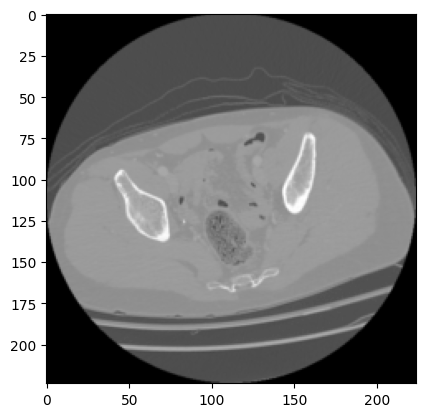

In [28]:
dicom_data = pydicom.dcmread(top_similar_images[32627][8][0])
pixel_data = dicom_data.pixel_array / 255.0  # Normalize pixel data
image = Image.fromarray(pixel_data)
if transform is not None:
    image = transform(image)
plt.imshow(image.squeeze(), cmap='gray')
plt.show();

In [29]:
# CREATING TNE NEW DATA TRAIN LOADER FOR THE MODEL THAT PREDICT THE LABELS


# Define a new custom dataset for the top similar images
class TopSimilarImagesDataset(torch.utils.data.Dataset):
    def __init__(self, similar_images, labels_dict, transform=None):
        self.similar_images = similar_images
        self.labels_dict = labels_dict
        self.transform = transform

    def __len__(self):
        return sum(len(images) for images in self.similar_images.values())

    def __getitem__(self, index):
        # Find the corresponding patient and image index
        for patient_id, images in self.similar_images.items():
            if index < len(images):
                image_path, _ = images[index]
                break
            index -= len(images)
        
        dicom_data = pydicom.dcmread(image_path)
        pixel_data = dicom_data.pixel_array / 255.0
        image = Image.fromarray(pixel_data)
        if self.transform is not None:
            image = self.transform(image)
        
        patient_id = int(image_path.split('/')[-3])
        label = torch.tensor(self.labels_dict[patient_id], dtype=torch.float32).float()

        return image, label

# Create an instance of the new dataset
top_similar_images_dataset = TopSimilarImagesDataset(top_similar_images, labels_dict, transform=transform)

# Create a DataLoader for the new dataset
top_similar_images_loader = DataLoader(top_similar_images_dataset, batch_size=batch_size, shuffle=True)

In [30]:
# CREATING MODEL TO PRODUCE LABELS

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = models.densenet121(pretrained=False)
        in_features = self.base_model.classifier.in_features
        
        # Modify the first layer to accept 1 channel instead of 3
        self.base_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        densenet_model.load_state_dict(torch.load('/kaggle/working/densenet121.pth'))

        
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, num_classes),
            #nn.Sigmoid()  # Sigmoid for multi-label classification
            nn.Softmax(dim=1)  # Softmax for multi-label classification
        )
        
    def forward(self, x):
        return self.base_model(x)

model = CustomModel(num_classes=13)

In [31]:
# DEFINING THE LOSS AND OPTIMIZATION

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# TRAINING OF MY MODEL

print_every = 40  # Define how often to print the loss

for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize a running loss variable
    for batch_idx, (images, labels) in enumerate(top_similar_images_loader):
        #print(f'Batch {batch_idx+1}/{len(top_similar_images_loader)}, Epoch {epoch+1}/{num_epochs}')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(f'Loss: {loss.item():.4f}')
        
        if (batch_idx + 1) % print_every == 0:  # Print every print_every batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(top_similar_images_loader)}], Loss: {running_loss/print_every:.4f}')
            running_loss = 0.0  # Reset the running loss

In [33]:
# Saving model
torch.save(model.state_dict(), 'model.pth')

In [34]:
import csv

#  Creating the csv file
testing_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/'
image_paths=[]
for dirname, _, filenames in os.walk(testing_dir):
    
    for filename in filenames:
        
        image_paths.append(os.path.join(dirname, filename))

# List to store the results
results = []

# Iterate over each image
for image_path in image_paths:
    print(image_path)
    dicom_data = pydicom.dcmread(image_path)
    pixel_data = dicom_data.pixel_array / 255.0
    image = Image.fromarray(pixel_data)
    
    if transform is not None:
        image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(image)
        labels = (outputs ).float()  # Assuming binary classification

    # Get patient ID from image path
    patient_id = image_path.split('/')[-2]

    # Convert labels to list for CSV
    labels_list = labels.squeeze().tolist()

    # Append results
    results.append([patient_id] + labels_list)

# Define the CSV file path
csv_file_path = 'submission.csv'

# Write results to a CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy', 'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high'])
    # Write the data
    writer.writerows(results)

print(f'Results saved to {csv_file_path}')


/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/63706/39279/30.dcm
/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/50046/24574/30.dcm
/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/48843/62825/30.dcm
Results saved to submission.csv


In [35]:
pd.read_csv('submission.csv')


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,39279,0.274310,0.000138,0.218362,0.000190,0.235687,0.000181,0.000149,0.002861,0.009650,0.000195,0.258034,0.000103,0.000138
1,24574,0.276095,0.000147,0.218894,0.000198,0.234031,0.000193,0.000158,0.002919,0.010360,0.000210,0.256542,0.000108,0.000145
2,62825,0.274247,0.000162,0.221375,0.000217,0.237133,0.000210,0.000177,0.003041,0.010855,0.000225,0.252083,0.000118,0.000156


In [36]:
# Define hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 32

In [37]:
# TRAINING OF MY MODEL

print_every = 40  # Define how often to print the loss

for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize a running loss variable
    for batch_idx, (images, labels) in enumerate(top_similar_images_loader):
        #print(f'Batch {batch_idx+1}/{len(top_similar_images_loader)}, Epoch {epoch+1}/{num_epochs}')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(f'Loss: {loss.item():.4f}')
        
        if (batch_idx + 1) % print_every == 0:  # Print every print_every batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(top_similar_images_loader)}], Loss: {running_loss/print_every:.4f}')
            running_loss = 0.0  # Reset the running loss

In [38]:
# Saving model
torch.save(model.state_dict(), 'model2.pth')